In [1]:
#### library package
pacman::p_load(Seurat, dplyr, ggplot2, stringr, magrittr, reticulate, reshape2, tidyverse, ggsci, knitr, harmony, cowplot, RColorBrewer, anndata,
               tidyr, patchwork, ggrepel, homologene, scico, DropletUtils, scCustomize, tidydr, Matrix, DoubletFinder, data.table, ggpubr, 
               ggthemes, extrafont, sysfonts, viridis, openxlsx, paletteer)

[1] 502908

# load data

In [ ]:
obj.ccRCC <- readRDS('/project/sex_cancer/data/ccRCC_Hu2024/snRNA.rds')

# modify meta.data

In [ ]:
info <- read_xlsx('/project/sex_cancer/data/ccRCC_Hu2024/ccRCC_Hu2024PatientInfo.xlsx', skip = 1)

names(info)[1] <- 'sample'
info1 <- info[info$sample%in%unique(obj.ccRCC@meta.data$sample),]
info1$Sex=gsub('male','M',info1$Sex)
info1$Sex=gsub('female','F',info1$Sex)

meta <- obj.ccRCC@meta.data %>% transform(barcode = rownames(.))
meta <- merge(meta, info1, by = 'sample',all = TRUE) %>% column_to_rownames('barcode') %>% .[colnames(obj.ccRCC),]

In [2]:
# modify meta.data
obj.ccRCC@meta.data <- meta@meta.data %>%
                       transform(barcode = rownames(.), Cohort = 'ccRCC_Hu2024', orig.ident = sample) %>%
                       dplyr::rename(c('SampleID' = 'sample', 'percent.mt' = 'percent.mito')) %>%
                       dplyr::select(-c('nUMI', 'nGene', 'class'))

In [1]:
## add sample info
sample_info <- openxlsx::read.xlsx('/project/sex_cancer/data/ccRCC_Hu2024/41588_2024_1662_MOESM4_ESM.xlsx', startRow = 2, rowNames = TRUE)
sample_info <-  sample_info %>%
                transform(SampleID = rownames(.)) %>% 
                subset(SampleID %in% obj.ccRCC$SampleID) %>%
                dplyr::rename(c('Sex' = 'sex'))

obj.ccRCC@meta.data <- obj.ccRCC@meta.data %>% 
                       merge(sample_info, by = 'SampleID', all = TRUE) %>%
                       transform(SampleType = 'tumor', DonorID = SampleID) %>%
                       `rownames<-`(.$barcode)

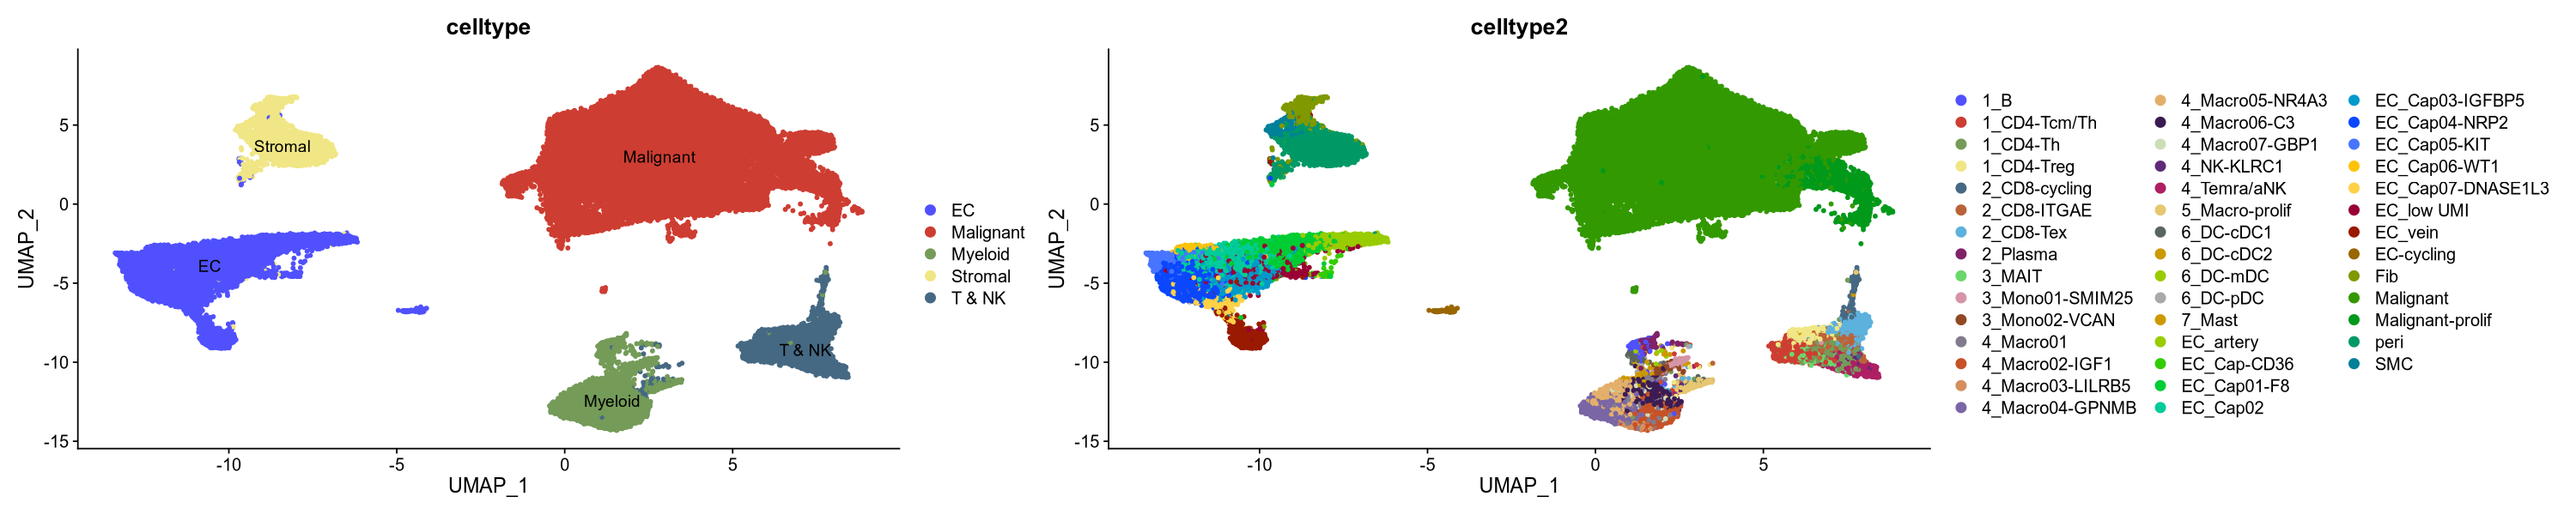

In [10]:
options(repr.plot.height = 5, repr.plot.width = 25)
DimPlot_scCustom(obj.ccRCC, pt.size = 1, group.by = "celltype", reduction = 'umap', label = T, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ccRCC, pt.size = 1, group.by = "celltype2", reduction = 'umap', label = F, colors_use = pal_igv("default")(51))

# cell type annotation

## assign mCT

In [14]:
obj.ccRCC@meta.data  <-  obj.ccRCC@meta.data %>%
                         mutate(mCT = case_when(celltype %in% c('Malignant') ~ 'Tumor',
                                                celltype2 %in% c('1_B', '2_Plasma') ~ 'B',
                                                celltype2 %in% c('1_CD4-Tcm/Th', '1_CD4-Th') ~ 'CD4T',
                                                celltype2 %in% c('1_CD4-Treg') ~ 'Treg',
                                                celltype2 %in% c('2_CD8-cycling', '2_CD8-ITGAE', '2_CD8-Tex') ~ 'CD8T',
                                                celltype2 %in% c('3_MAIT') ~ 'MAIT',
                                                celltype2 %in% c('4_NK-KLRC1', '4_Temra/aNK') ~ 'NK',
                                                celltype2 %in% c('4_Macro01', '4_Macro02-IGF1', '4_Macro03-LILRB5', '4_Macro04-GPNMB', 
                                                                 '4_Macro05-NR4A3', '4_Macro06-C3', '4_Macro07-GBP1', '5_Macro-prolif') ~ 'Mph',
                                                celltype2 %in% c('6_DC-cDC1', '6_DC-cDC2', '6_DC-pDC', '6_DC-mDC') ~ 'DC',
                                                celltype2 %in% c('3_Mono01-SMIM25', '3_Mono02-VCAN') ~ 'Mono',
                                                celltype2 %in% c('7_Mast') ~ 'Mast',
                                                celltype2 %in% c('peri') ~ 'Pericyte',
                                                celltype2 %in% c('EC_Cap01-F8', 'EC_artery', 'EC_Cap04-NRP2', 'EC_low UMI', 'EC-cycling', 'EC_vein', 
                                                                 'EC_Cap03-IGFBP5', 'EC_Cap02', 'EC_Cap07-DNASE1L3', 'EC_Cap05-KIT', 'EC_Cap06-WT1', 'EC_Cap-CD36') ~ 'Endo',
                                                celltype2 %in% c('Fib') ~ 'Fibro',
                                                celltype2 %in% c('SMC') ~ 'SMC',
                                                TRUE ~ 'Others'  # 对于其他情况，D列设置为NA 比如设置为Unknow的
                                                ))
table(obj.ccRCC$celltype2, obj.ccRCC$mCT)

                   
                        B  CD4T  CD8T    DC  Endo Fibro  MAIT  Mast  Mono   Mph
  1_B                 397     0     0     0     0     0     0     0     0     0
  1_CD4-Tcm/Th          0  1106     0     0     0     0     0     0     0     0
  1_CD4-Th              0   877     0     0     0     0     0     0     0     0
  1_CD4-Treg            0     0     0     0     0     0     0     0     0     0
  2_CD8-cycling         0     0   203     0     0     0     0     0     0     0
  2_CD8-ITGAE           0     0   618     0     0     0     0     0     0     0
  2_CD8-Tex             0     0   995     0     0     0     0     0     0     0
  2_Plasma            169     0     0     0     0     0     0     0     0     0
  3_MAIT                0     0     0     0     0     0   302     0     0     0
  3_Mono01-SMIM25       0     0     0     0     0     0     0     0   329     0
  3_Mono02-VCAN         0     0     0     0     0     0     0     0   178     0
  4_Macro01         

## assign dCT

In [15]:
obj.ccRCC@meta.data  <-  obj.ccRCC@meta.data %>%
                         mutate(dCT = case_when(celltype %in% c('Malignant') ~ 'Tumor',
                                                celltype2 %in% c('1_B') ~ 'B',
                                                celltype2 %in% c('2_Plasma') ~ 'Plasma',
                                                celltype2 %in% c('1_CD4-Tcm/Th', '1_CD4-Th') ~ 'CD4T',
                                                celltype2 %in% c('1_CD4-Treg') ~ 'Treg',
                                                celltype2 %in% c('2_CD8-cycling', '2_CD8-ITGAE', '2_CD8-Tex') ~ 'CD8T',
                                                celltype2 %in% c('3_MAIT') ~ 'MAIT',
                                                celltype2 %in% c('4_NK-KLRC1', '4_Temra/aNK') ~ 'NK',
                                                celltype2 %in% c('4_Macro01', '4_Macro02-IGF1', '4_Macro03-LILRB5', '4_Macro04-GPNMB', 
                                                                 '4_Macro05-NR4A3', '4_Macro06-C3', '4_Macro07-GBP1', '5_Macro-prolif') ~ 'Mph',
                                                celltype2 %in% c('6_DC-cDC1', '6_DC-cDC2', '6_DC-pDC', '6_DC-mDC') ~ 'DC',
                                                celltype2 %in% c('3_Mono01-SMIM25', '3_Mono02-VCAN') ~ 'Mono',
                                                celltype2 %in% c('7_Mast') ~ 'Mast',
                                                celltype2 %in% c('peri') ~ 'Pericyte',
                                                celltype2 %in% c('EC_Cap01-F8', 'EC_artery', 'EC_Cap04-NRP2', 'EC_low UMI', 'EC-cycling', 'EC_vein', 
                                                                 'EC_Cap03-IGFBP5', 'EC_Cap02', 'EC_Cap07-DNASE1L3', 'EC_Cap05-KIT', 'EC_Cap06-WT1', 'EC_Cap-CD36') ~ 'Endo',
                                                celltype2 %in% c('Fib') ~ 'Fibro',
                                                celltype2 %in% c('SMC') ~ 'SMC',
                                                TRUE ~ 'Others'  # 对于其他情况，D列设置为NA 比如设置为Unknow的
                                                ))
table(obj.ccRCC$celltype2, obj.ccRCC$dCT)

                   
                        B  CD4T  CD8T    DC  Endo Fibro  MAIT  Mast  Mono   Mph
  1_B                 397     0     0     0     0     0     0     0     0     0
  1_CD4-Tcm/Th          0  1106     0     0     0     0     0     0     0     0
  1_CD4-Th              0   877     0     0     0     0     0     0     0     0
  1_CD4-Treg            0     0     0     0     0     0     0     0     0     0
  2_CD8-cycling         0     0   203     0     0     0     0     0     0     0
  2_CD8-ITGAE           0     0   618     0     0     0     0     0     0     0
  2_CD8-Tex             0     0   995     0     0     0     0     0     0     0
  2_Plasma              0     0     0     0     0     0     0     0     0     0
  3_MAIT                0     0     0     0     0     0   302     0     0     0
  3_Mono01-SMIM25       0     0     0     0     0     0     0     0   329     0
  3_Mono02-VCAN         0     0     0     0     0     0     0     0   178     0
  4_Macro01         

## assign gCT

In [17]:
obj.ccRCC@meta.data  <-  obj.ccRCC@meta.data %>%
                         mutate(gCT = case_when(mCT %in% c('Tumor') ~ 'Tumor',
                                                mCT %in% c('B', 'CD4T', 'Treg', 'CD8T', 'MAIT', 'NK', 'Mph', 'DC', 'Mono', 'Mast') ~ 'Immune',
                                                mCT %in% c('Pericyte', 'Endo', 'Fibro', 'SMC') ~ 'Stromal',
                                                TRUE ~ 'Others'  # 对于其他情况，D列设置为NA 比如设置为Unknow的
                                                ))
table(obj.ccRCC$mCT, obj.ccRCC$gCT)

          
           Immune Stromal Tumor
  B           566       0     0
  CD4T       1983       0     0
  CD8T       1816       0     0
  DC          268       0     0
  Endo          0   17222     0
  Fibro         0     989     0
  MAIT        302       0     0
  Mast         26       0     0
  Mono        507       0     0
  Mph        5371       0     0
  NK          931       0     0
  Pericyte      0    4394     0
  SMC           0     351     0
  Treg        446       0     0
  Tumor         0       0 62806

## assign oCT

In [18]:
obj.ccRCC@meta.data <- obj.ccRCC@meta.data %>%
                       transform(oCT = celltype2)

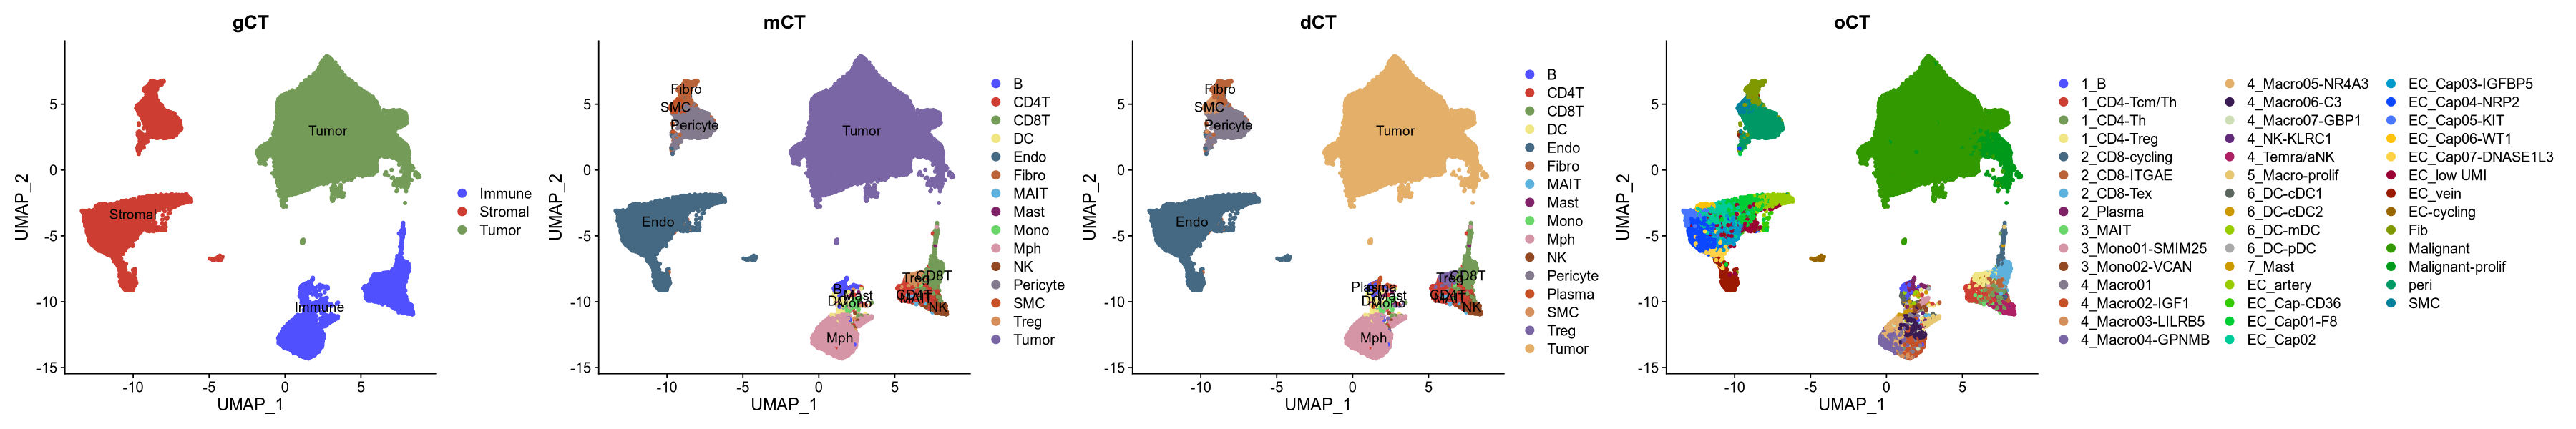

In [19]:
options(repr.plot.height = 5, repr.plot.width = 30)
DimPlot_scCustom(obj.ccRCC, pt.size = 1, group.by = "gCT", reduction = 'umap', label = T, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ccRCC, pt.size = 1, group.by = "mCT", reduction = 'umap', label = T, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ccRCC, pt.size = 1, group.by = "dCT", reduction = 'umap', label = T, label.size = 4, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ccRCC, pt.size = 1, group.by = "oCT", reduction = 'umap', label = F, colors_use = pal_igv("default")(51))

In [51]:
meta_now[,c('SampleType', 'Sex', 'SampleID')] %>% .[!duplicated(.$SampleID),] %$% table(.$SampleType, .$Sex)
table(meta_now$SampleType)

       
         F  M
  tumor  6 14


tumor 
97978 

# save

In [57]:
saveRDS(obj.ccRCC, 'obj.ccRCC.use.rds')